In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.models import Sequential
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2020-09-28","2021-11-24")
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data['Prediction']=data['Close'].shift(-1)
# data['H-L'] = data['High'] - data['Low']
# data['O-C'] = data['Close'] - data['Open']
# # data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
# data["% Change"]=data["Close"].pct_change()
# data['3day MA'] = data['Close'].rolling(window = 7).mean()
# data['10day MA'] = data['Close'].rolling(window = 14).mean()
# data['30day MA'] = data['Close'].rolling(window = 21).mean()
# data['Std_dev']= data['Close'].rolling(5).std()
# # data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2020-09-28,28.350000,31.299999,28.250000,30.799999,29.670927,150402170,30.000000
2020-09-29,30.850000,31.400000,30.000000,30.000000,28.900255,55920302,29.799999
2020-09-30,30.500000,30.500000,29.650000,29.799999,28.707586,35285507,31.000000
2020-10-05,30.700001,31.900000,30.700001,31.000000,29.863596,69650604,31.049999
2020-10-06,31.100000,31.200001,30.750000,31.049999,29.911764,28877682,31.549999
...,...,...,...,...,...,...,...
2021-11-17,45.700001,46.000000,45.650002,46.000000,46.000000,12386061,46.049999
2021-11-18,46.000000,46.299999,45.799999,46.049999,46.049999,8437935,46.049999
2021-11-19,46.099998,46.099998,45.650002,46.049999,46.049999,8203492,45.549999


In [4]:
df = yf.Ticker('0005.hk').history(period = 'max')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,56.925592,57.182013,55.130640,55.387062,3908164,0.0,0
2000-01-04,54.361366,54.617788,53.848523,54.361366,6895378,0.0,0
2000-01-05,51.797170,52.310014,51.027905,51.540749,14657098,0.0,0
2000-01-06,51.797173,52.310017,49.361168,49.745800,10632084,0.0,0
2000-01-07,50.515062,51.797170,50.002219,51.540749,8368286,0.0,0
...,...,...,...,...,...,...,...
2021-11-24,46.000000,46.450001,45.849998,46.099998,12898992,0.0,0
2021-11-25,46.099998,46.500000,45.549999,46.150002,9840572,0.0,0
2021-11-26,45.650002,45.799999,44.299999,44.349998,28426743,0.0,0


In [5]:
# data['Next 5-days MA']=data['Prediction'].rolling(5).mean()
# data
data[::-1].rolling(5).mean()

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2021-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-17,45.72,46.01,45.55,45.830000,45.830000,9917580.0,NaN
...,...,...,...,...,...,...,...
2020-10-06,31.37,31.57,31.00,31.380000,30.229667,25700143.6,31.270000
2020-10-05,31.23,31.61,30.93,31.290000,30.142966,32844048.8,31.380000
2020-09-30,31.03,31.40,30.66,30.959999,29.825063,35742999.0,31.290000


In [6]:
data[::-1]

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2021-11-23,45.400002,45.950001,45.349998,45.500000,45.500000,7401789,NaN
2021-11-22,45.400002,45.700001,45.299999,45.549999,45.549999,13158623,45.500000
2021-11-19,46.099998,46.099998,45.650002,46.049999,46.049999,8203492,45.549999
2021-11-18,46.000000,46.299999,45.799999,46.049999,46.049999,8437935,46.049999
2021-11-17,45.700001,46.000000,45.650002,46.000000,46.000000,12386061,46.049999
...,...,...,...,...,...,...,...
2020-10-06,31.100000,31.200001,30.750000,31.049999,29.911764,28877682,31.549999
2020-10-05,30.700001,31.900000,30.700001,31.000000,29.863596,69650604,31.049999
2020-09-30,30.500000,30.500000,29.650000,29.799999,28.707586,35285507,31.000000


In [7]:
# data[::-1]['Prediction'].rolling(5).

In [8]:
# data[::-1].dropna().head(5)
data['5-days forward MA']=talib.MA(data['Close'],5)
data

,Open,High,Low,Close,Adj Close,Volume,Prediction,5-days forward MA
Date,,,,,,,,
2020-09-28,28.350000,31.299999,28.250000,30.799999,29.670927,150402170,30.000000,NaN
2020-09-29,30.850000,31.400000,30.000000,30.000000,28.900255,55920302,29.799999,NaN
2020-09-30,30.500000,30.500000,29.650000,29.799999,28.707586,35285507,31.000000,NaN
2020-10-05,30.700001,31.900000,30.700001,31.000000,29.863596,69650604,31.049999,NaN
2020-10-06,31.100000,31.200001,30.750000,31.049999,29.911764,28877682,31.549999,30.530000
...,...,...,...,...,...,...,...,...
2021-11-17,45.700001,46.000000,45.650002,46.000000,46.000000,12386061,46.049999,45.550000
2021-11-18,46.000000,46.299999,45.799999,46.049999,46.049999,8437935,46.049999,45.670000
2021-11-19,46.099998,46.099998,45.650002,46.049999,46.049999,8203492,45.549999,45.820000


In [9]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Prediction,5-days forward MA
Date,,,,,,,,
2021-11-10,45.299999,45.349998,44.599998,45.299999,45.299999,18905544,45.450001,45.830000
2021-11-11,45.000000,45.799999,44.900002,45.450001,45.450001,14576796,45.299999,45.490000
2021-11-12,45.450001,45.599998,45.049999,45.299999,45.299999,8890298,45.200001,45.460000
2021-11-15,45.000000,45.400002,44.900002,45.200001,45.200001,7145701,45.799999,45.360000
2021-11-16,45.549999,45.950001,45.450001,45.799999,45.799999,12596153,46.000000,45.410000
2021-11-17,45.700001,46.000000,45.650002,46.000000,46.000000,12386061,46.049999,45.550000
2021-11-18,46.000000,46.299999,45.799999,46.049999,46.049999,8437935,46.049999,45.670000
2021-11-19,46.099998,46.099998,45.650002,46.049999,46.049999,8203492,45.549999,45.820000
2021-11-22,45.400002,45.700001,45.299999,45.549999,45.549999,13158623,45.500000,45.889999


In [10]:
data.dropna(inplace=True)
data.drop('Prediction',1,inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,5-days forward MA
Date,,,,,,,
2021-11-16,45.549999,45.950001,45.450001,45.799999,45.799999,12596153,45.410000
2021-11-17,45.700001,46.000000,45.650002,46.000000,46.000000,12386061,45.550000
2021-11-18,46.000000,46.299999,45.799999,46.049999,46.049999,8437935,45.670000
2021-11-19,46.099998,46.099998,45.650002,46.049999,46.049999,8203492,45.820000
2021-11-22,45.400002,45.700001,45.299999,45.549999,45.549999,13158623,45.889999


In [11]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ["Open","High","Low","Close","Adj Close","Volume","5-days forward MA"]
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
X_test = min_max_scaler.transform(df_test.loc[:,train_cols])
X_train, y_train = build_timeseries(x_train, 6)
X_train = trim_dataset(X_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 6)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
# print(x_test.shape)
print("Batch trimmed size", X_train.shape, y_train.shape)

Train--Test size 223 56
Length of inputs 213
length of time-series - inputs (213, 10, 7)
length of time-series - outputs (213,)
Length of inputs 46
length of time-series - inputs (46, 10, 7)
length of time-series - outputs (46,)
Batch trimmed size (200, 10, 7) (200,)


In [12]:
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(100, dropout=0.0))
    lstm_model.add(Dropout(0.2))
    
#     lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss="MSE", optimizer=optimizer)
  
    return lstm_model

lstm_model = None
lstm_model = create_lstm_model()
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 10, 100)             43200     
_________________________________________________________________
dropout (Dropout)            (20, 10, 100)             0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 100)                 80400     
_________________________________________________________________
dropout_1 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense (Dense)                (20, 1)                   101       
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________
None


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:357: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(X_train, y_train, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)))

Epoch 1/300
10/10 [==============================] - 1s 27ms/step - loss: 0.2516 - val_loss: 0.1315
Epoch 2/300
10/10 [==============================] - 0s 27ms/step - loss: 0.1325 - val_loss: 0.0418
Epoch 3/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0427 - val_loss: 0.0047
Epoch 4/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0146 - val_loss: 0.0305
Epoch 5/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0227 - val_loss: 0.0171
Epoch 6/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0161 - val_loss: 0.0068
Epoch 7/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0157 - val_loss: 0.0072
Epoch 8/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0128 - val_loss: 0.0097
Epoch 9/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0136 - val_loss: 0.0095
Epoch 10/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0149 - val_loss: 0.0085

10/10 [==============================] - 0s 24ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 83/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 84/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 85/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 86/300
10/10 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 87/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 88/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 89/300
10/10 [==============================] - 0s 24ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 90/300
10/10 [==============================] - 0s 24ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 91/300
10/10 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: 0.0021
Epo

10/10 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 163/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 164/300
10/10 [==============================] - 0s 25ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 165/300
10/10 [==============================] - 0s 27ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 166/300
10/10 [==============================] - 0s 27ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 167/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 168/300
10/10 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 169/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 170/300
10/10 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 171/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0027 - val_loss: 0

10/10 [==============================] - 0s 29ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 243/300
10/10 [==============================] - 0s 31ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 244/300
10/10 [==============================] - 0s 28ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 245/300
10/10 [==============================] - 0s 30ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 246/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 247/300
10/10 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 248/300
10/10 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 249/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 250/300
10/10 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 251/300
10/10 [==============================] - 0s 29ms/step - loss: 0.0026 - val_loss: 0

In [19]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[6]) + min_max_scaler.data_min_[6]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[6]) + min_max_scaler.data_min_[6]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.00168109544234065 (20,) (20,)
[0.6939963  0.72424924 0.7468578  0.76474625 0.7787277  0.7918394
 0.80246323 0.8169496  0.8325117  0.84147674 0.8474232  0.8460373
 0.8441187  0.84066    0.8378369 ]
[0.77115987 0.79519333 0.8092999  0.82549634 0.83019854 0.8354232
 0.84952977 0.86520375 0.87042841 0.87722048 0.87983281 0.87513061
 0.86468129 0.86624871 0.84848485]
[43.73309  44.31213  44.744858 45.087242 45.354847 45.605804 45.809147
 46.086414 46.384274 46.555862 46.669678 46.643154 46.60643  46.54023
 46.4862  ]
[45.20999985 45.67000046 45.94000015 46.25       46.34000015 46.44000015
 46.70999985 47.00999985 47.10999985 47.24000015 47.29000015 47.2
 47.         47.03000031 46.69000015]


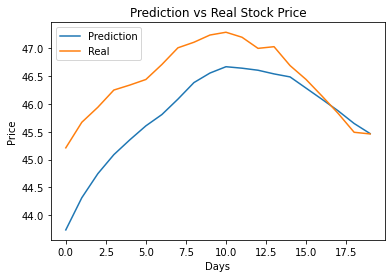

In [20]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

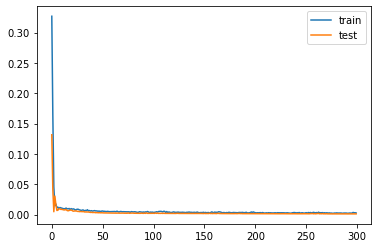

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [22]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
df = yf.download('0005.hk',"2021-09-20","2021-11-30")
df['5-days forward MA']=talib.MA(df['Close'],5)
df.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,5-days forward MA
Date,,,,,,,
2021-09-20,39.900002,39.950001,38.950001,39.000000,39.000000,23796781,NaN
2021-09-21,38.349998,39.000000,38.299999,38.799999,38.799999,18117762,NaN
2021-09-23,39.299999,39.950001,39.200001,39.750000,39.750000,20518033,NaN
2021-09-24,40.200001,40.799999,39.700001,39.700001,39.700001,19052618,NaN
2021-09-27,40.000000,41.099998,40.000000,40.299999,40.299999,20332913,39.51
2021-09-28,41.250000,41.250000,40.599998,40.849998,40.849998,29545281,39.88
2021-09-29,40.500000,41.599998,40.299999,41.250000,41.250000,30287737,40.37
2021-09-30,41.000000,41.299999,40.599998,40.950001,40.950001,13928675,40.61
2021-10-04,40.599998,40.799999,40.049999,40.500000,40.500000,21964896,40.77


In [23]:
data['y_pred'] = np.NaN
data.iloc[(len(data) - len(y_pred)):,-1:] = y_pred_org
data.dropna()

,Open,High,Low,Close,Adj Close,Volume,5-days forward MA,y_pred
Date,,,,,,,,
2021-10-26,47.299999,47.500000,47.099998,47.500000,47.500000,31599646,46.710000,43.733089
2021-10-27,47.549999,48.000000,47.500000,47.849998,47.849998,20701724,47.010000,44.312130
2021-10-28,47.400002,47.400002,46.500000,47.000000,47.000000,27836706,47.110000,44.744858
2021-10-29,47.049999,47.150002,46.400002,47.150002,47.150002,18167634,47.240000,45.087242
2021-11-01,46.549999,47.000000,46.349998,46.950001,46.950001,12419384,47.290000,45.354847
2021-11-02,47.450001,47.599998,46.950001,47.049999,47.049999,10828361,47.200000,45.605804
2021-11-03,46.799999,47.099998,46.500000,46.849998,46.849998,9965448,47.000000,45.809147
2021-11-04,47.049999,47.150002,46.700001,47.150002,47.150002,11599843,47.030000,46.086414
2021-11-05,45.000000,45.500000,44.599998,45.450001,45.450001,32926856,46.690000,46.384274
